In [0]:
# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np



# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()





def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()



def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()


def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))


IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),transforms.ToTensor()])


train_dataset = dsets.MNIST(root='./data',train=True,transform=composed,download=True)
validation_dataset = dsets.MNIST(root='./data',train=False,transform=composed,download=True)

In [0]:
C = 0
class CNN(nn.Module):
  def __init__(self,out1=16,out2=32):
    super(CNN,self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1,out_channels=out1,kernel_size=5,padding=2)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.cnn2 = nn.Conv2d(in_channels=out1,out_channels=out2,kernel_size=5,padding=2)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    self.fc1 = nn.Linear(out2 * 4 * 4, 10)

  def forward(self,x):
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)
    out = out.view(out.size(0),-1)
    # print(out.shape[1]) # Number of input neurons
    out = self.fc1(out)
    return out
  
  def activations(self,x):
    c1 = self.cnn1(x)
    r1 = self.relu1(c1)
    out = self.maxpool1(r1)

    c2 = self.cnn2(out)
    r2 = self.relu2(c2)
    out = self.maxpool2(r2)

    out = out.view(out.size(0),-1)
    return c1,r1,c2,r2,out

model = CNN(out1=16, out2=32)

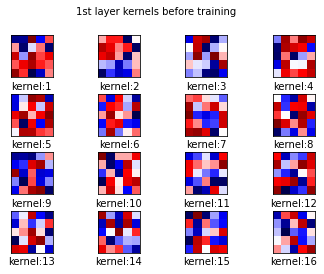

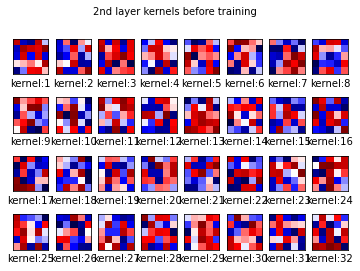

In [45]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [0]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [0]:
n_epochs=3
loss_list=[]
accuracy_list=[]
N_test=len(validation_dataset)

def train_model(n_epochs):
  for epoch in range(n_epochs):

    for x,y in train_loader:
      z = model(x)
      loss = criterion(z,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    correct=0
    for x,y in validation_loader:
      z = model(x)
      _,yhat = z.max(1)
      correct+=(yhat==y).sum().item()
    acc = correct / N_test 
    accuracy_list.append(acc)
    loss_list.append(loss.data)

train_model(n_epochs)


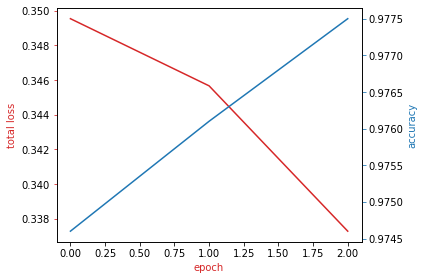

In [52]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

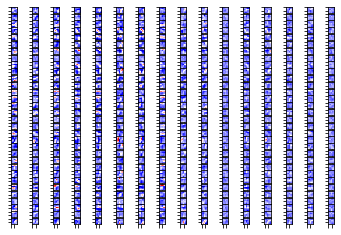

In [53]:
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

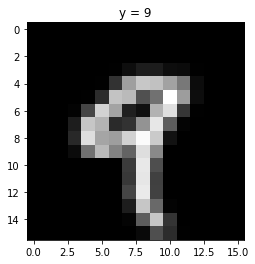

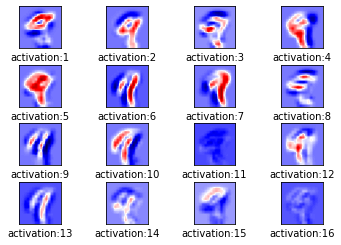

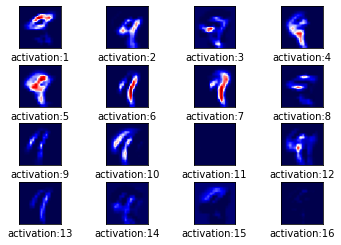

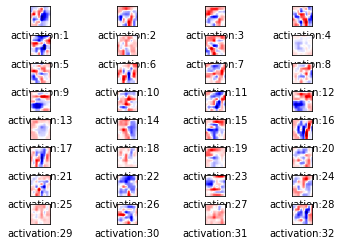

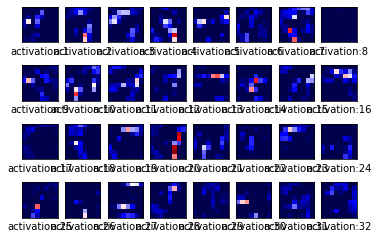

In [56]:
test_subject = train_dataset[4]
show_data(test_subject)
out = model.activations(test_subject[0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

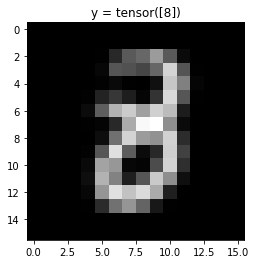

yhat:  tensor([3])


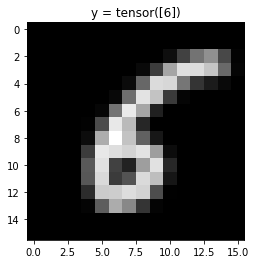

yhat:  tensor([5])


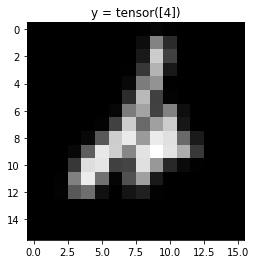

yhat:  tensor([2])


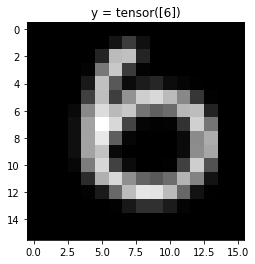

yhat:  tensor([0])


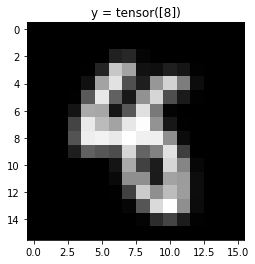

yhat:  tensor([4])


In [57]:

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  
    